# Impact at Home Plate
### By: Kevin Smith 08/18/2022
---

Whether you are a Major League Baseball coach making lineup decisions, or a general manager making free agency decisions, there is a lot to consider when putting your team together. Analytics have been great in part because they aschewed tradtional baseball wisdom and allowed teams to find new paths to success. The impact metric just might be something that can bridge the gap between analytics and "old school baseball."

## Project Goal
---
The goal of this project is to build a model to predict a players offensive wins above replacement (owar) utilizing machine learning and a metric that i invented called "impact."

being able to utilize impact in both free agent and lineup decisions simplifies the process by utilizing both analytics and tradition baseball wisdom.

We will be walking through a basic data science pipeline to reach our goal today. The steps in the pipeline are:

* Planning
* Acqusition
* Prep
* Exploration
* Clustering
* Feature Engineering
* Modeling
* Delivery

### Steps For Reproduction
---

1. Clone my repo (including the , <mark>acquire.py</mark>. <mark>explore.py</mark> , <mark>stats.csv</mark>, <mark>value.csv</mark>, <mark>model.py</mark> & <mark>wrangle.py</mark>files.
2. The libraries used are pandas, numpy, scipy, matplotlib, seaborn, and sklearn.
3. You should now be able to run the <mark>zillow_final_cluster.ipynb</mark> file.

## Planning
---
Their are two essential parts to any good plan. Identify your **Goals**, and the necessary **Steps** to get there. 

### Goals:
1. Identify variables driving owar.
2. Develop a model to make value predicitons based on those variable. 
3. Deliver actionable takeaways

### Steps:
1. Initial hypothesis
2. Acquire and cache the dataset
3. Clean, prep, and split the data to prevent data leakage
4. Do some preliminary exploration of the data (including visualiztions and statistical analyses)
5. Create meaningful clusters
6. Trim dataset of variables that are not statistically significant
7. Determine which machine learning model perfoms the best
8. Utilize the best model on the test dataset
9. Create a final report notebook with streamlined code optimized for a technical audience



## Data Library
---
| **Variable Name** | **Explanation** | **Values** |
| :---: | :---: | :---: |
| last | the players last name | object |
| first | the players first name | object |
| id | unique identification code | Numeric value |
| year | the year of the season of the observation | Numeric value |
| name | The players full name | object |
| team | Code representing the team played for during observation | object|
| owar | offensive wins above replacement | Numeric value |
| age | age of player during season in years | Numeric value |
| ops| on-base + slugging-pct | Numeric value |
| tb | total bases | Numeric vaue |
| pitches_faced | number of puitches faced by batter during season | Numeric value |
| pull | the percentage of balls hit to the 'pull' side | Numeric value |
| center| the percetage of balls hit 'up the middle' | Numeric value |
| oppo | percentage of balls hit to the 'opposite' side | Numeric value |
| batted | number of balls the hitter made contact with during the season | Numeric value |
| raa | runs above average | Numeric value|
| waa | wins above average | Numeric value |
| impact | measure of players average impact per plate appearance| Numeric value |
| ppa | number of pitches seen in average plate appearance | Numeric value |


In [24]:
# importing dependencies
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression , LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

import acquire
from wrangle import mlb_wrangle
import explore
from model import baseline_model,linear_model,lasso_model,poly_model

import warnings
warnings.filterwarnings("ignore")


## acquire and clean
---

This includes pulling multiple csv files from 2 different reputable baseball statistics sites and merging them together to create a dataframe with the data that was needed in order to complete the project. 

**csv files were downloaded from multiple sites and are current to 08/15/2022. For up to date data, follow the steps outlined in the wrangle.ipynb file**

In [25]:
# bringing in, cleaning, and prepping the data. nulls were dropped in every category but salary. 
# missing salary entries were imputed with the median salary of the train dataframe after splitting.

train, validate, test = mlb_wrangle()

## explore
---

Asking questions about the relationships of different variables and then creating clusters based on those relationships. 

### question 1:
Do raa, waa, and ops have a relationship?

In [26]:
# what is the relationship between raa, waa, and ops?

# h0: no relationship
# ha: relationship

r, p = stats.pearsonr(train.raa, train.waa)
print(f'r = {r:.5f}')
print(f'p = {p:.1f}')

r, p = stats.spearmanr(train.raa, train.ops)
print(f'r = {r:.5f}')
print(f'p = {p:.1f}')

r, p = stats.spearmanr(train.waa, train.ops)
print(f'r = {r:.5f}')
print(f'p = {p:.1f}')

# we can be confident that raa and waa have a very strong linear relationship to each other, and the both have a
# decent non-linear relationship to ops

r = 0.99574
p = 0.0
r = 0.49971
p = 0.0
r = 0.50318
p = 0.0


The answer is we can be confident that they do. raa and waa have a very strong linear correlation to each other, and they both have a fairly strong non-linear correlation to ops. prime candidates from clustering

### question 2:

Do pull, center, and oppo have a relationship?


Text(0.5, 1.0, 'linear relationship between pull and center')

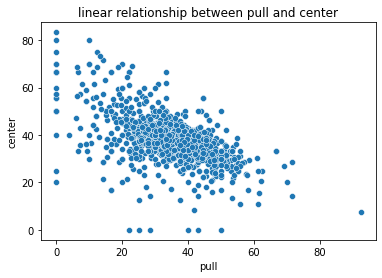

In [27]:
sns.scatterplot(data=train, x='pull',y='center')
plt.title('linear relationship between pull and center')

The answer is that it is slight, and it is noisy, but a pearsonr test confirms what the visualization suggests. We can be confident that there is a slight linear relationship between pull, and center. Which is logical considering they both represent percentages of a whole.

### question 3:

Does impact correlate with owar?

Text(0.5, 1.0, 'non-linear relationship between impact and owar')

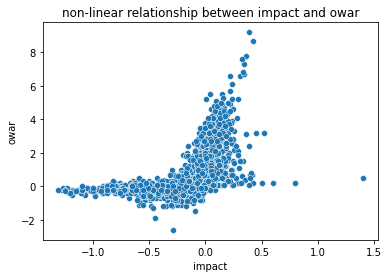

In [28]:
sns.scatterplot(data=train, x='impact',y='owar')
plt.title('non-linear relationship between impact and owar')

In [29]:
# h0: no relationship
# ha: relationship

r, p = stats.spearmanr(train.impact, train.owar)
print(f'r = {r:.5f}')
print(f'p = {p:.1f}')

# we can be very confident that there is a fairly strong relationship between impact and our target variable

r = 0.74511
p = 0.0


The answer is that we can be confident that our new metric has a pretty strong non-linear relationship with our target variable. Which likely means that impact is going to be a useful feature when predicting owar.

Other variables appear to have non-linear relationships with impact as well, but we do not have time to explore them all.

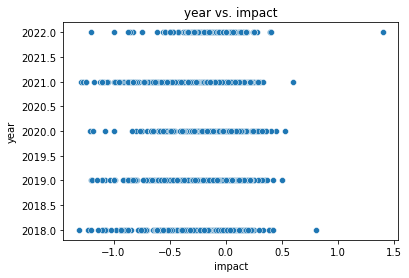

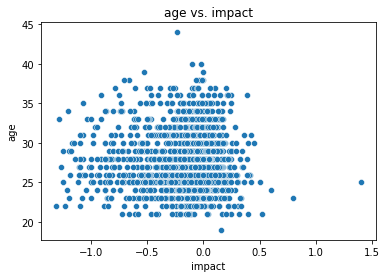

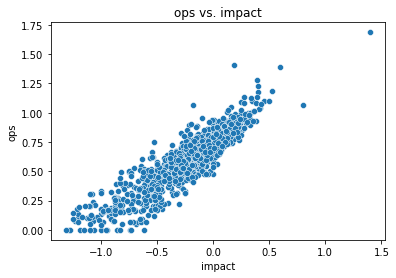

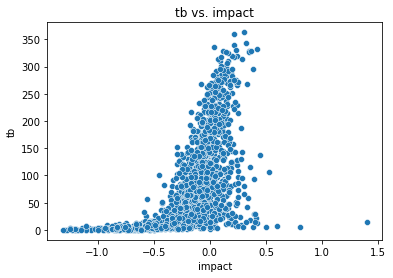

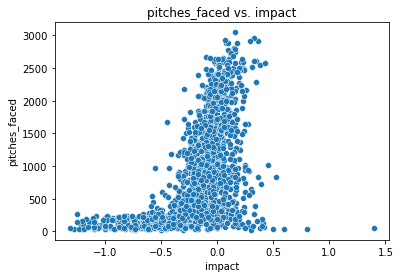

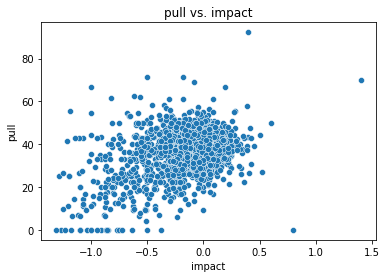

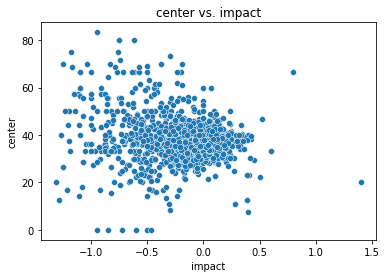

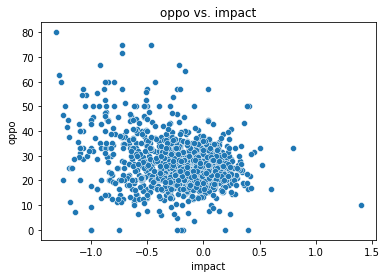

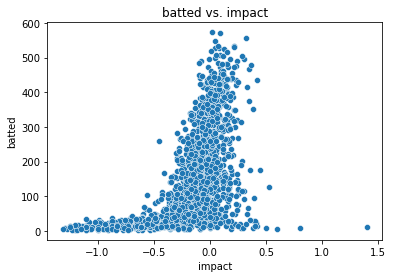

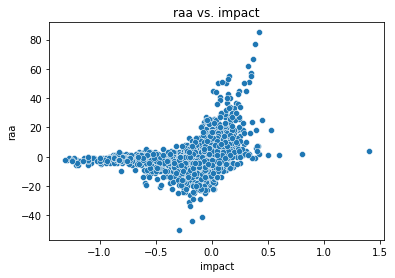

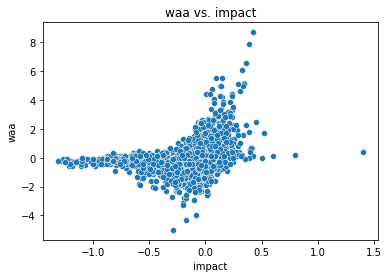

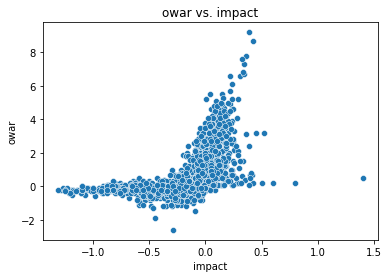

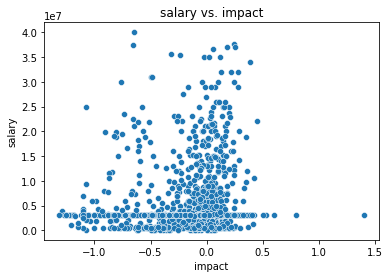

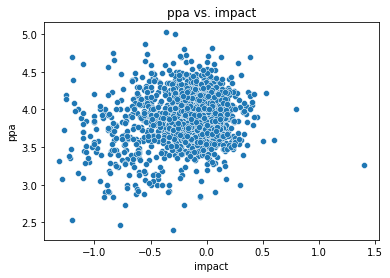

In [30]:
for i in train.drop(columns=['index_x','name','last','first','id','team','playerid','impact']).columns.tolist():
    sns.scatterplot(data=train, x='impact', y=i)
    plt.title(i + ' vs. impact')
    plt.show()

### clustering
---
Here we are creating variable based on the features we identified as having relationships during our exploration phase.

In [31]:
train,validate,test = explore.model_prep(train,validate,test)

## Modeling
---

 This is where we discover that the polynomial model performs the best when predicting owar. This is likely because of the non-linear relationship between impact (and other variables), and owar.

In [32]:
baseline_model(train,validate,test)

RMSE using Mean
Train/In-Sample:  1.34 
Validate/Out-of-Sample:  1.43
RMSE using Median
Train/In-Sample:  1.42 
Validate/Out-of-Sample:  1.53


In [33]:
linear_model(train,validate,test)

['scaled_ops', 'scaled_tb', 'scaled_pitches_faced', 'scaled_batted', 'scaled_raa', 'scaled_waa', 'scaled_impact']
RMSE using OLS
Train/In-Sample:  0.37 
Validate/Out-of-Sample:  0.38


In [35]:
lasso_model(train,validate,test)

['scaled_ops', 'scaled_tb', 'scaled_pitches_faced', 'scaled_batted', 'scaled_raa', 'scaled_waa', 'scaled_impact']
RMSE using Lasso
Train/In-Sample:  1.34 
Validate/Out-of-Sample:  1.43


In [37]:
poly_model(train,validate,test)

['scaled_ops', 'scaled_tb', 'scaled_pitches_faced', 'scaled_batted', 'scaled_raa', 'scaled_waa', 'scaled_impact']
RMSE using Polynomial
Train/In-Sample:  0.3 
Validate/Out-of-Sample:  0.32
RMSE using Polynomial 
Test/Out-of-sample;  0.41


## Delivery
---
So, you may be wondering how you will be able to use this model to make decisions.

1. By keeping track of a players impact at the plate over the course of the season, managers can make lineup decisions based on a players recent impact level knowing that it is a key driver in how many wins above or below that player is likely to be on that given day.

2. When making free agency decisions the general manager can take into account the average impact that player has had at the plate over the course of previous seasons, and decide if they would rather have a player with a lower average impact who is more consistent, or a player who has short bursts of dominance at the plate.

3. Using the model we outperformed the baseline predicting owar by 132%

## Conclusion
---

In conclusion, with more time, and more robust data sources I would be able to track a players impact at the plate and identify potential free agents that would fit the identity of the team because of the metrics reliance on both analytics and tradition baseball wisdom. 